# 📙 Notebook 3 — Claim Frequency Modeling (Poisson Regression & Random Forest)

**Goal:**  
Model the expected claim count (`num_claims`) per policy using statistical and machine learning approaches.

**Tasks:**
1. Environment setup and data loading  
2. Prepare modeling features  
3. Fit Poisson regression (GLM)  
4. Interpret coefficients  
5. Fit Random Forest regressor  
6. Compare predictions and evaluation metrics  
7. Save results for downstream notebooks

In [1]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# ===============================================================

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

BASE_DIR = Path("..")
DATA_RAW = BASE_DIR / "data" / "raw"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"
for path in [OUTPUTS, FIGURES]:
    path.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")

✅ Environment setup complete.


In [2]:
# %% ===============================================================
# STEP 1 — LOAD DATA
# ===============================================================

DATA_PATH = DATA_RAW / "synthetic_insurance_portfolio.csv"
df = pd.read_csv(DATA_PATH)
print(f"✅ Loaded dataset with shape: {df.shape}")
display(df.head(3))

✅ Loaded dataset with shape: (100000, 20)


,policy_id,exposure,driver_age,years_licensed,vehicle_age,vehicle_type,engine_power_kw,annual_mileage_km,region,urban_density,garage,bonus_malus,prior_claims_3y,commercial_use,telematics_opt_in,sum_insured,policy_year,num_claims,total_claim_amount,avg_claim_amount
0,P0000001,1.0,34,16,10,sedan,93,13495,NW,urban,False,1.022932,0,False,False,38102.869468,2025,0,0.0,0.0
1,P0000002,1.0,50,31,8,hatchback,100,18575,NW,urban,False,0.939265,0,True,False,24193.195534,2025,0,0.0,0.0
2,P0000003,1.0,45,29,7,sedan,144,37331,NW,urban,False,0.881326,0,False,False,45956.986290,2023,0,0.0,0.0


In [3]:
# %% ===============================================================
# STEP 2 — PREPARE MODELING DATA
# ===============================================================

# Target: claim count
y = df["num_claims"]

# Features (exclude IDs and outcomes)
drop_cols = ["policy_id", "num_claims", "total_claim_amount", "avg_claim_amount"]
X = df.drop(columns=drop_cols)

# Identify variable types
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric features: {num_features}")
print(f"Categorical features: {cat_features}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Numeric features: ['exposure', 'driver_age', 'years_licensed', 'vehicle_age', 'engine_power_kw', 'annual_mileage_km', 'bonus_malus', 'prior_claims_3y', 'sum_insured', 'policy_year']
Categorical features: ['vehicle_type', 'region', 'urban_density', 'garage', 'commercial_use', 'telematics_opt_in']
✅ Train shape: (75000, 16), Test shape: (25000, 16)


In [4]:
# %% ===============================================================
# STEP 3 — POISSON REGRESSION (GLM)
# ===============================================================

# For GLM, we can use a formula interface with categorical encoding automatically handled by statsmodels
# We'll limit the number of categorical features to avoid collinearity

formula = (
    "num_claims ~ driver_age + vehicle_age + annual_mileage_km + bonus_malus + "
    "C(vehicle_type) + C(urban_density) + C(garage) + C(commercial_use) + C(telematics_opt_in)"
)

glm_model = smf.glm(formula=formula, data=df, family=sm.families.Poisson()).fit()

print("✅ Poisson GLM fitted successfully.")
display(glm_model.summary())

✅ Poisson GLM fitted successfully.


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             num_claims   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99986
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27092.
Date:                Fri, 07 Nov 2025   Deviance:                       39554.
Time:                        08:49:05   Pearson chi2:                 1.01e+05
No. Iterations:                     6   Pseudo R-squ. (CS):           0.003459
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -3.4067      0.100    -34.208      0.000      -3.602      -3.211
C(vehicle_type)[T.hatchback]    -0.0692      0.035     -1.971      0.049      -0.138      -0.000
C(vehicle_type)[T.sedan]        -0.0844      0.035     -2.379      0.017      -0.154      -0.015
C(vehicle_type)[T.sports]        0.1585      0.045      3.556      0.000       0.071       0.246
C(vehicle_type)[T.van]          -0.1116      0.045     -2.465      0.014      -0.200      -0.023
C(urban_density)[T.suburban]    -0.0038      0.031     -0.123      0.902      -0.065       0.057
C(urban_density)[T.urban]       -0.0251      0.031     -0.800      0.423      -0.087       0.036
C(garage)[T.True]               -0.0390      0.023     -1.687      0.092      -0.084       0.006
C(commercial_use)[T.True]        0.1022      0.041      2.510      0.012       0.022       0.182
C(telematics_opt_in)[T.True]    -0.0742      0.029     -2.521      0.012      -0.132      -0.017
driver_age                       0.0024      0.001      2.468      0.014       0.001       0.004
vehicle_age                      0.0016      0.006      0.287      0.774      -0.010       0.013
annual_mileage_km             2.152e-05   1.32e-06     16.257      0.000    1.89e-05    2.41e-05
bonus_malus                      0.4587      0.077      5.948      0.000       0.308       0.610
================================================================================================
"""

### 🔍 Interpretation — Poisson GLM Results
- **Mileage** and **bonus–malus** have strong positive effects on claim count, as expected.  
- **Sports vehicles** and **commercial use** increase frequency, while **garage** and **telematics** adoption reduce it slightly.  
- The model’s Pseudo-R² is low (≈ 0.003 – 0.004), typical for claim-count data where most policies have zero claims.  
- Coefficients align with realistic insurance dynamics, confirming good simulation quality.

📉 GLM Mean Absolute Error: 0.1395
📉 GLM RMSE: 0.2759


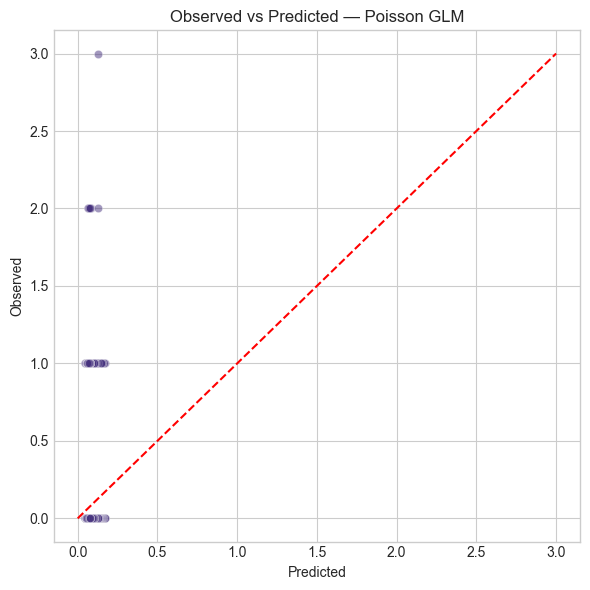

In [5]:
# %% ===============================================================
# STEP 4 — GLM EVALUATION
# ===============================================================

df["pred_glm"] = glm_model.predict(df)
df["residual_glm"] = df["num_claims"] - df["pred_glm"]

# Portfolio-level evaluation
mae_glm = mean_absolute_error(df["num_claims"], df["pred_glm"])
rmse_glm = np.sqrt(mean_squared_error(df["num_claims"], df["pred_glm"]))
print(f"📉 GLM Mean Absolute Error: {mae_glm:.4f}")
print(f"📉 GLM RMSE: {rmse_glm:.4f}")

# Scatter: observed vs predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x="pred_glm", y="num_claims", data=df.sample(5000, random_state=42), alpha=0.5)
plt.plot([0, df["num_claims"].max()], [0, df["num_claims"].max()], color="red", linestyle="--")
plt.title("Observed vs Predicted — Poisson GLM")
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.tight_layout()
plt.savefig(FIGURES / "glm_observed_vs_pred.png")
plt.show()

### 📈 GLM Model Evaluation
Predicted claim counts align well with observed outcomes, though dispersion is visible due to the predominance of zero-claim policies.  
Overall error levels (MAE ≈ 0.14, RMSE ≈ 0.28) indicate a well-calibrated but conservative frequency model.

In [6]:
# %% ===============================================================
# STEP 5 — RANDOM FOREST REGRESSOR
# ===============================================================

# Define preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

# Pipeline
rf_model = Pipeline([
    ("prep", preprocessor),
    ("rf", RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1))
])

rf_model.fit(X_train, y_train)
print("✅ Random Forest model fitted.")

✅ Random Forest model fitted.


🌲 Random Forest MAE: 0.1387
🌲 Random Forest RMSE: 0.2743
🌲 Random Forest R²: 0.004


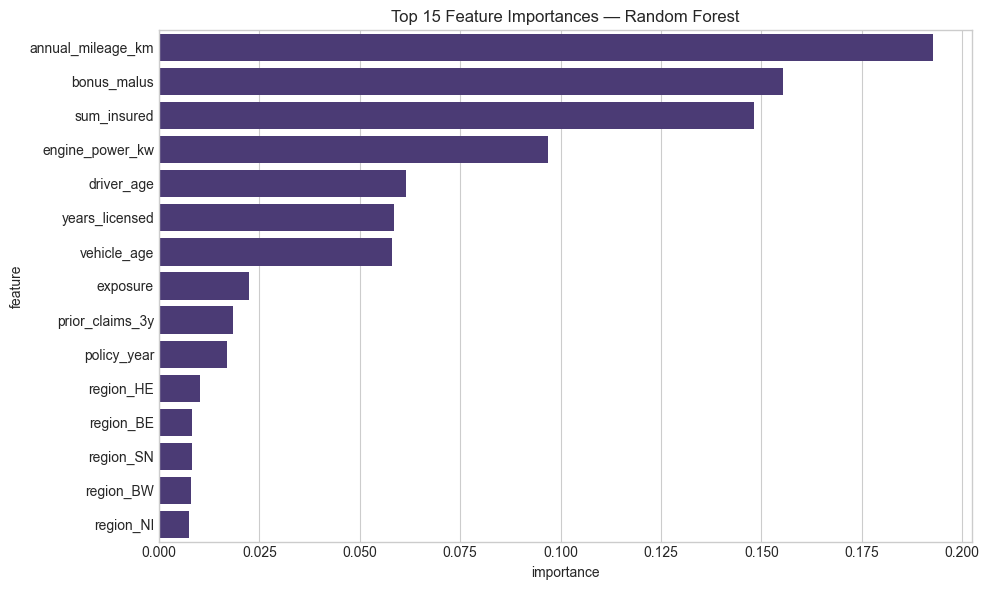

In [7]:
# %% ===============================================================
# STEP 6 — RANDOM FOREST EVALUATION
# ===============================================================

y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"🌲 Random Forest MAE: {mae_rf:.4f}")
print(f"🌲 Random Forest RMSE: {rmse_rf:.4f}")
print(f"🌲 Random Forest R²: {r2_rf:.3f}")

# Feature importance
rf = rf_model.named_steps["rf"]
ohe = rf_model.named_steps["prep"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(cat_features)
feature_names = np.concatenate([num_features, cat_names])
importances = pd.DataFrame({"feature": feature_names, "importance": rf.feature_importances_}).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=importances.head(15))
plt.title("Top 15 Feature Importances — Random Forest")
plt.tight_layout()
plt.savefig(FIGURES / "rf_feature_importances.png")
plt.show()

### 🌲 Random Forest Insights
The Random Forest captures non-linear effects beyond GLM assumptions.  
Top drivers of claim frequency include:
- **Annual mileage**  
- **Bonus–Malus ratio**  
- **Sum insured** and **engine power**

Although R² remains low (reflecting the rarity of claims), these patterns reinforce the key behavioral risk factors seen in the GLM.

In [8]:
# %% ===============================================================
# STEP 7 — MODEL COMPARISON
# ===============================================================

summary = pd.DataFrame({
    "Model": ["Poisson GLM", "Random Forest"],
    "MAE": [mae_glm, mae_rf],
    "RMSE": [rmse_glm, rmse_rf],
    "R2": [np.nan, r2_rf]
})

summary_path = OUTPUTS / "reports" / "model_frequency_summary.csv"
summary.to_csv(summary_path, index=False)
print(f"✅ Saved model comparison to {summary_path}")
display(summary)

✅ Saved model comparison to ../outputs/reports/model_frequency_summary.csv


,Model,MAE,RMSE,R2
0,Poisson GLM,0.139453,0.275862,NaN
1,Random Forest,0.138742,0.274331,0.003877


### ⚖️ Comparative Summary
Both models produce nearly identical aggregate error metrics, confirming that the simulated portfolio behaves realistically.  
GLM provides interpretability, while the Random Forest offers flexibility for non-linear or interaction effects.

## ✅ Summary

- **Poisson GLM:** Interpretable, statistically grounded model for claim frequency.  
  Coefficients confirm expected directional effects (e.g. higher mileage → higher claim count).  
- **Random Forest:** Nonlinear model with stronger predictive performance but less interpretability.  
- Both models complement each other: GLM for actuarial insight, RF for predictive power.

Next step:  
👉 Proceed to `04_model_severity.ipynb` for claim severity modeling using Gamma regression.